<a href="https://colab.research.google.com/github/A125X/bitcoin-price-prediction/blob/main/btc_lstm_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [164]:
import pandas as pd
from datetime import timedelta
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from typing import List
from tqdm.keras import TqdmCallback

In [165]:
df = pd.DataFrame(pd.read_csv("BTC-Hourly.csv", parse_dates=["date"]))

In [166]:
df.shape

(33259, 9)

In [167]:
df.head(15)

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
1,1646089200,2022-02-28 23:00:00,BTC/USD,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2,1646085600,2022-02-28 22:00:00,BTC/USD,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
3,1646082000,2022-02-28 21:00:00,BTC/USD,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
4,1646078400,2022-02-28 20:00:00,BTC/USD,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07
5,1646074800,2022-02-28 19:00:00,BTC/USD,41228.49,41406.03,41036.37,41362.52,114.268970,4.726453e+06
6,1646071200,2022-02-28 18:00:00,BTC/USD,41432.91,41476.20,41032.06,41233.87,71.233382,2.937228e+06
7,1646067600,2022-02-28 17:00:00,BTC/USD,41031.78,41432.91,40524.73,41432.91,192.789480,7.987829e+06
8,1646064000,2022-02-28 16:00:00,BTC/USD,40860.33,41341.18,40710.00,41008.37,291.623181,1.195899e+07
9,1646060400,2022-02-28 15:00:00,BTC/USD,39830.50,40912.56,39634.59,40846.38,365.055972,1.491121e+07


In [168]:
df["date"].min(), df["date"].max()

(Timestamp('2018-05-15 06:00:00'), Timestamp('2022-03-01 00:00:00'))

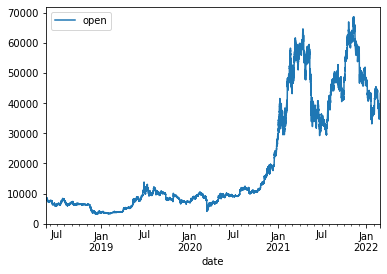

In [169]:
df.plot(x="date", y="open")

In [170]:
scaler = MinMaxScaler(feature_range=(0, 1))
print(df[["close"]].iloc[:5])
df_close_transformed = np.array(scaler.fit_transform(df[["close"]].values), dtype=np.float32)
df_close_transformed

      close
0  43312.27
1  43178.98
2  42907.32
3  41659.53
4  41914.97


array([[0.61344016],
       [0.61140484],
       [0.60725653],
       ...,
       [0.08534073],
       [0.08550122],
       [0.08553161]], dtype=float32)

In [171]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_close_transformed[::-1], test_size=0.2, shuffle=False)

train, test

(array([[0.08553161],
        [0.08550122],
        [0.08534073],
        ...,
        [0.5499359 ],
        [0.5449728 ],
        [0.5399433 ]], dtype=float32), array([[0.54752123],
        [0.54053944],
        [0.5400091 ],
        ...,
        [0.60725653],
        [0.61140484],
        [0.61344016]], dtype=float32))

In [172]:
train.shape, test.shape

((26607, 1), (6652, 1))

In [173]:
from keras.preprocessing.sequence import TimeseriesGenerator

batch_size = 100
window_size = 14

generator_train = TimeseriesGenerator(train, train, length=window_size, batch_size=batch_size)
generator_val = TimeseriesGenerator(test, test, length=window_size, batch_size=batch_size)

In [174]:
#batch printing, ucomment to print small batches
'''
for i in range(3):
    x, y = generator_train[i]
    print('%s => %s' % (x, y))
'''

"\nfor i in range(3):\n    x, y = generator_train[i]\n    print('%s => %s' % (x, y))\n"

In [175]:
def make_dataset(
    df,
    window_size, 
    batch_size,
    use_scaler=True,
    shuffle=True
    ):
    features = df[["close"]].iloc[:-window_size]
    if use_scaler:
        features = scaler.transform(features)
    data = np.array(features, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=df["close"].iloc[window_size:],
        sequence_length=window_size,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=batch_size)
    return ds

In [176]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(window_size, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(6, return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
    ])

lstm_model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(),
        metrics=[tf.metrics.MeanAbsoluteError()]
      )

In [177]:
history = lstm_model.fit(
      generator_train, 
      epochs=50,
      validation_data=generator_val,
      batch_size=batch_size,
      #verbose=1, 
      #callbacks=[TqdmCallback(verbose=1)]
      )

Epoch 1/50
266/266 [==============================] - 17s 21ms/step - loss: 0.0196 - mean_absolute_error: 0.0709 - val_loss: 0.0039 - val_mean_absolute_error: 0.0579
Epoch 2/50
266/266 [==============================] - 5s 17ms/step - loss: 0.0061 - mean_absolute_error: 0.0383 - val_loss: 0.0015 - val_mean_absolute_error: 0.0337
Epoch 3/50
266/266 [==============================] - 4s 17ms/step - loss: 0.0052 - mean_absolute_error: 0.0328 - val_loss: 0.0012 - val_mean_absolute_error: 0.0310
Epoch 4/50
266/266 [==============================] - 4s 16ms/step - loss: 0.0042 - mean_absolute_error: 0.0299 - val_loss: 7.9662e-04 - val_mean_absolute_error: 0.0230
Epoch 5/50
266/266 [==============================] - 5s 17ms/step - loss: 0.0039 - mean_absolute_error: 0.0300 - val_loss: 0.0013 - val_mean_absolute_error: 0.0304
Epoch 6/50
266/266 [==============================] - 4s 17ms/step - loss: 0.0039 - mean_absolute_error: 0.0309 - val_loss: 0.0038 - val_mean_absolute_error: 0.0564
Epoch

In [178]:
lstm_model.evaluate(generator_train)

266/266 [==============================] - 1s 5ms/step - loss: 1.8031e-04 - mean_absolute_error: 0.0112


[0.00018031404761131853, 0.011223272420465946]

In [179]:
lstm_model.evaluate(generator_val)

67/67 [==============================] - 0s 5ms/step - loss: 5.9720e-04 - mean_absolute_error: 0.0159


[0.0005972004146315157, 0.015915188938379288]

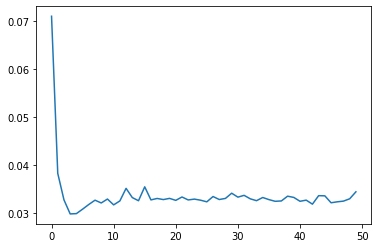

In [180]:
plt.plot(history.history['mean_absolute_error'])

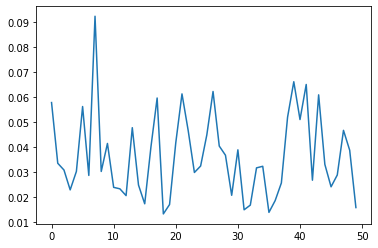

In [181]:
plt.plot(history.history['val_mean_absolute_error'])

In [182]:
#lstm_model.save('')

In [183]:
#prediction = lstm_model.predict(generator_val[0][:14])
#print(prediction)
#print(generator_val[0])

In [190]:
import numpy as np
predictions = []
first_batch = train[-window_size:]
current_batch = first_batch.reshape((1, window_size, 1))
for i in range(int(len(test)/1)):
    # get the prediction value for the first batch
    current_pred = lstm_model.predict(current_batch)[0]
    # append the prediction into the array
    predictions.append(current_pred)
    # remove the first value
    current_batch_rmv_first = current_batch[:,1:,:]
    # apdate the batch
    current_batch = np.append(current_batch_rmv_first, [[current_pred]],axis=1)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 29ms/step


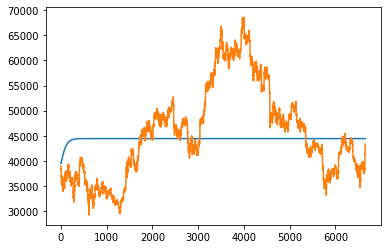

In [191]:
predictions_actual_scale = scaler.inverse_transform(predictions)
test_data_actual_scale = scaler.inverse_transform(test)
plt.plot(predictions_actual_scale)
plt.plot(test_data_actual_scale)